# Q-Learning: From Basics to Implementation

## What is Reinforcement Learning?

Reinforcement learning (RL) is learning through trial and error—similar to how you might learn a new game by experimenting with different moves. An agent interacts with an environment, takes actions, and receives feedback in the form of rewards or penalties. Over time, the agent learns to choose actions that lead to better long-term outcomes.

Unlike supervised learning (which learns from labeled examples) or unsupervised learning (which finds patterns in data), RL learns from consequences. It's well-suited for sequential decision-making problems like robotics, game-playing, and resource optimization.

### Model-Based vs Model-Free RL

There are two main approaches:

**Model-Based RL:** The agent builds an internal model of how the environment works, then uses this model to plan ahead before taking actions.

**Model-Free RL:** The agent learns directly from experience which actions work best, without building an explicit model of the environment.

Q-Learning is a popular **model-free** method that we'll focus on in this notebook.

---

## What is Q-Learning?

Q-Learning is a model-free reinforcement learning algorithm that learns the value of actions in different states. It maintains a table of "Q-values" (Quality values) that represent how good each action is in each situation.

### How Q-Learning Works

1. **Q-Table:** The agent maintains a table where each entry Q(state, action) represents the expected future reward for taking that action in that state
2. **Trial and Error:** The agent tries actions and observes the results
3. **Learning:** After each action, the agent updates its Q-values based on the reward received
4. **Improvement:** With enough practice, the Q-values converge to guide the agent toward optimal decisions

The beauty of Q-Learning is that the agent doesn't need to understand the full rules of the environment—it learns an effective strategy purely from experience.

### Key Properties

**Off-Policy Learning:** Q-Learning can learn the optimal policy while following a different (often exploratory) policy during training

**Discrete Spaces:** Works naturally with discrete state and action spaces

**Value-Based:** Learns the value of actions rather than learning a policy directly

---

## Implementation

Let's implement Q-Learning step by step, visualizing how the agent learns over time.

### Step 1: Setting Up the Environment

We'll use a simple 3×3 grid world where the agent can explore. The agent starts at the top-left and tries to reach the bottom-right goal.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 6x6 grid world
grid_size = 6
n_states = grid_size * grid_size  # 36 states
n_actions = 4  # Up, Down, Left, Right

# Visualize the grid
fig, ax = plt.subplots(figsize=(10, 10))
grid = np.arange(n_states).reshape(grid_size, grid_size)

# Create the grid visualization
for i in range(grid_size):
    for j in range(grid_size):
        state_num = grid[i, j]
        rect = plt.Rectangle((j, grid_size-1-i), 1, 1, 
                            fill=True, facecolor='lightblue', 
                            edgecolor='black', linewidth=2)
        ax.add_patch(rect)
        ax.text(j + 0.5, grid_size-1-i + 0.5, f'S{state_num}',
               ha='center', va='center', fontsize=12, fontweight='bold')

# Mark start and goal
ax.text(0.5, grid_size-0.3, 'START', ha='center', va='bottom', 
       fontsize=10, color='green', fontweight='bold')
ax.text(grid_size-0.5, 0.8, 'GOAL', ha='center', va='top', 
       fontsize=10, color='red', fontweight='bold')

ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Grid World Environment', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"Environment: {grid_size}×{grid_size} grid with {n_states} states")
print(f"Actions: {n_actions} (Up, Down, Left, Right)")

### Step 2: Initialize the Q-Table
The Q-table starts with all zeros. Each cell represents the expected future reward for taking a specific action in a specific state.

In [38]:
# Initialize Q-table
Q = np.zeros((n_states, n_actions))
action_names = ['Up', 'Down', 'Left', 'Right']

print("\nQ-table initialized with zeros")
print(f"Q-table shape: {Q.shape} (states × actions)")


Q-table initialized with zeros
Q-table shape: (36, 4) (states × actions)


### Step 3: Set Up Training Parameters

In [ ]:
# Hyperparameters
alpha = 0.1    # Learning rate: how much to update Q-values
gamma = 0.9    # Discount factor: how much to value future rewards
epsilon = 0.9  # Exploration rate: probability of random action
n_episodes = 1000

# Simple environment for our grid
class GridEnv:
    def __init__(self, grid_size=3):
        self.grid_size = grid_size
        self.n_states = grid_size * grid_size
        self.goal_state = self.n_states - 1  # Bottom-right
        
    def reset(self):
        return 0  # Start at top-left
    
    def step(self, state, action):
        # Convert state to grid coordinates
        row = state // self.grid_size
        col = state % self.grid_size
        
        # Apply action (0:Up, 1:Down, 2:Left, 3:Right)
        if action == 0:   # Up
            row = max(0, row - 1)
        elif action == 1: # Down
            row = min(self.grid_size - 1, row + 1)
        elif action == 2: # Left
            col = max(0, col - 1)
        elif action == 3: # Right
            col = min(self.grid_size - 1, col + 1)
        
        # Convert back to state number
        next_state = row * self.grid_size + col
        
        # Reward: +1 for reaching goal, -0.01 for each step
        reward = 1.0 if next_state == self.goal_state else -0.01
        done = (next_state == self.goal_state)
        
        return next_state, reward, done

env = GridEnv(grid_size)

print(f"\nTraining parameters:")
print(f"  Learning rate (α): {alpha}")
print(f"  Discount factor (γ): {gamma}")
print(f"  Initial exploration (ε): {epsilon}")
print(f"  Total episodes: {n_episodes}")

### Step 4: Training Loop with Checkpoints

In [ ]:
# Store Q-tables at different training stages
Q_checkpoints = {}
checkpoint_episodes = [333, 666, 1000]

# Store initial state (episode 0)
Q_checkpoints[0] = Q.copy()

# Training loop
for episode in range(1, n_episodes + 1):
    state = env.reset()
    done = False
    
    # Store checkpoint
    if episode in checkpoint_episodes:
        Q_checkpoints[episode] = Q.copy()
    
    while not done:
        # ε-greedy action selection
        if np.random.random() < epsilon:
            action = np.random.choice(n_actions)  # Explore
        else:
            action = np.argmax(Q[state])  # Exploit
        
        # Take action
        next_state, reward, done = env.step(state, action)
        
        # Q-Learning update rule
        Q[state, action] += alpha * (
            reward + gamma * np.max(Q[next_state]) 
            - Q[state, action]
        )
        
        state = next_state
    
    # Decay exploration over time
    epsilon = max(0.01, epsilon * 0.995)

print("\nTraining complete!")
print(f"Final exploration rate: {epsilon:.4f}")

### Step 5: Visualize Learning Progress
Now let's see how the Q-values evolved during training:

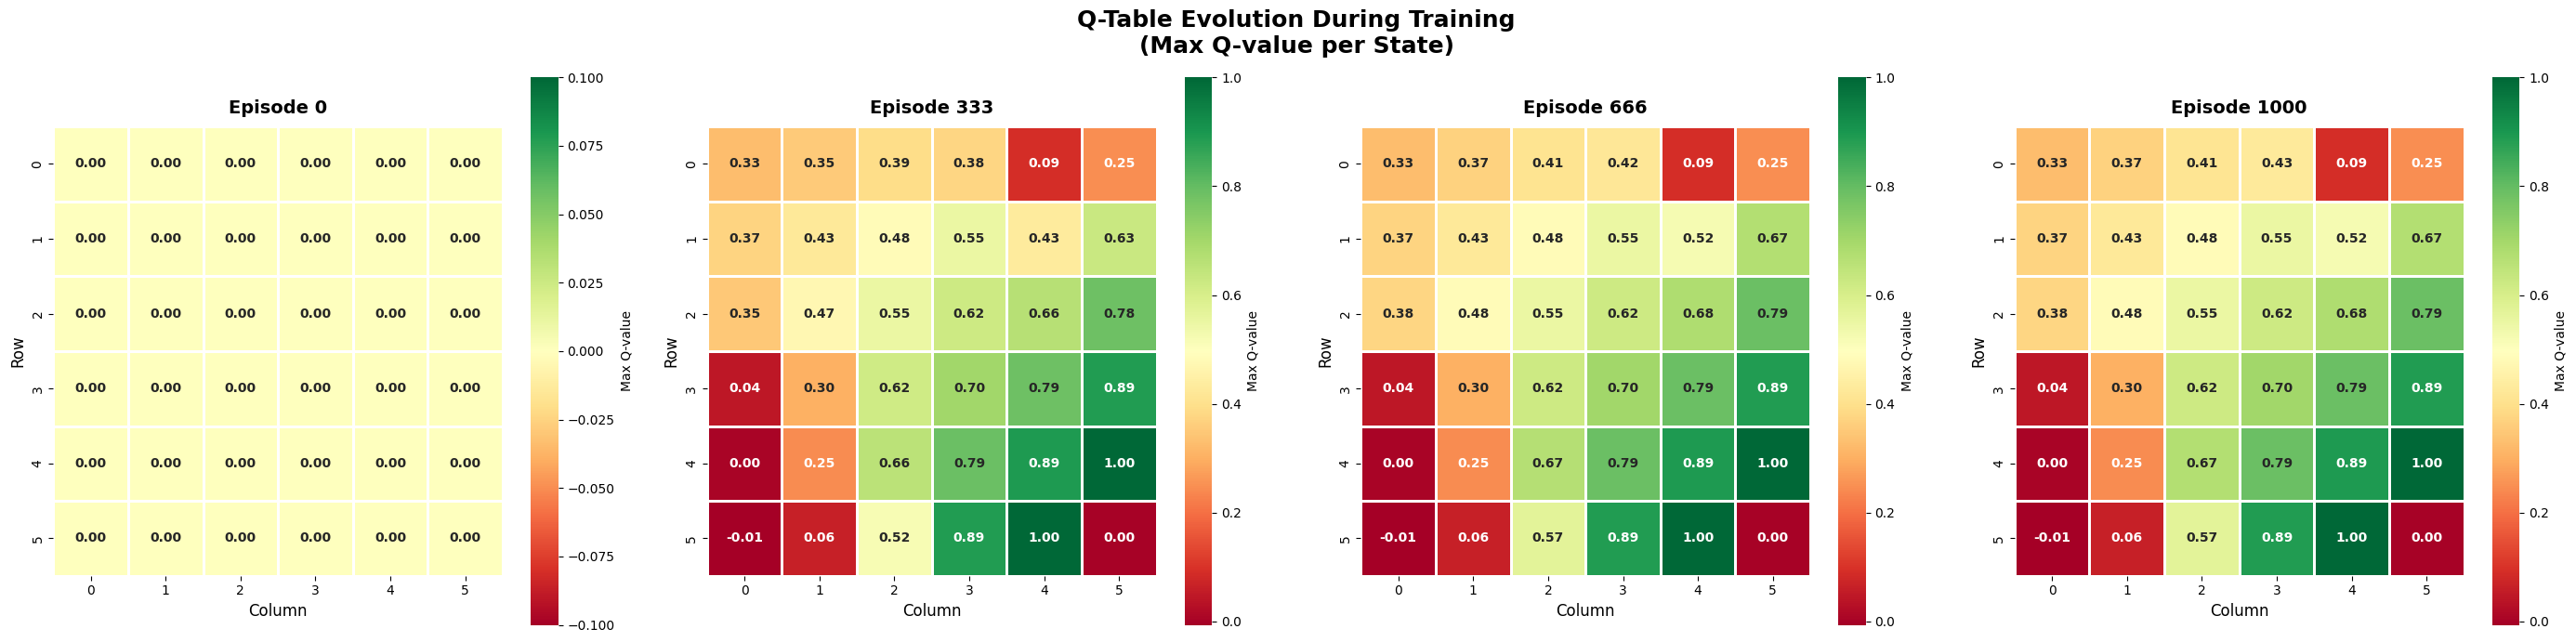


Observations:
- Early training (Episode 0): All Q-values are zero
- Mid training: Q-values start to increase near goal
- Late training: Clear gradient emerges toward goal
- Final: Q-values show optimal path value estimates


In [40]:
# Visualize Q-table evolution as grid world
fig, axes = plt.subplots(1, 4, figsize=(28, 7))
fig.suptitle('Q-Table Evolution During Training\n(Max Q-value per State)', 
             fontsize=18, fontweight='bold')

for idx, (episode, Q_snapshot) in enumerate(Q_checkpoints.items()):
    ax = axes[idx]
    
    # Get max Q-value for each state
    max_q_values = np.max(Q_snapshot, axis=1).reshape(grid_size, grid_size)
    
    # Use individual color scale for each checkpoint to see differences
    vmin = max_q_values.min()
    vmax = max_q_values.max()
    
    # Ensure we have some range for coloring
    if vmax - vmin < 0.01:
        vmin = -0.1
        vmax = 0.1
    
    sns.heatmap(max_q_values, annot=True, fmt='.2f', cmap='RdYlGn',
               center=(vmin + vmax) / 2, ax=ax, cbar_kws={'label': 'Max Q-value'},
               vmin=vmin, vmax=vmax, square=True, linewidths=2,
               annot_kws={'fontsize': 10, 'fontweight': 'bold'})
    
    ax.set_title(f'Episode {episode}', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Early training (Episode 0): All Q-values are zero")
print("- Mid training: Q-values start to increase near goal")
print("- Late training: Clear gradient emerges toward goal")
print("- Final: Q-values show optimal path value estimates")

## Understanding the Update Rule

The Q-Learning update uses temporal difference learning:
```
Q(s,a) ← Q(s,a) + α[r + γ max Q(s',a') - Q(s,a)]
```

Where:
* `α` (alpha): Learning rate—how much to update based on new information
* `γ` (gamma): Discount factor—how much to value future rewards
* `r`: Immediate reward received
* `max Q(s',a')`: Best possible future value from next state

This adjusts our estimates based on the difference between what we expected and what we actually observed.

## Exploration vs Exploitation

The ε-greedy strategy balances:
* Exploration: Trying random actions to discover new information (with probability ε)
* Exploitation: Choosing the best known action (with probability 1-ε)

Starting with high ε and gradually decreasing it allows the agent to explore early and exploit learned knowledge later.

## Limitations & Extensions

### The Scalability Problem

Q-tables become impractical with large or continuous state spaces. Consider a robot with 10 continuous position/velocity variables—it would need an infinite table!

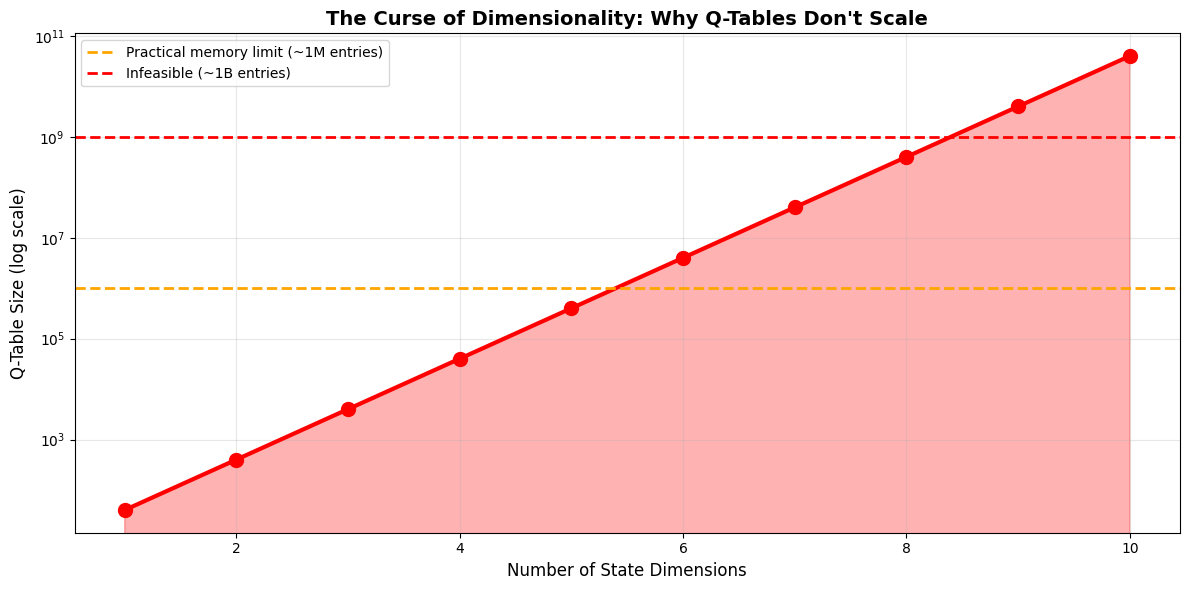


Q-tables grow exponentially with state dimensions!
This is why Deep Q-Networks (DQN) use neural networks instead


In [42]:
# Visualize scalability problem
state_dims = np.arange(1, 11)
states_per_dim = 10
actions = 4

table_sizes = (states_per_dim ** state_dims) * actions

fig, ax = plt.subplots(figsize=(12, 6))

ax.semilogy(state_dims, table_sizes, 'ro-', linewidth=3, markersize=10)
ax.fill_between(state_dims, table_sizes, alpha=0.3, color='red')

# Add threshold lines
ax.axhline(y=1e6, color='orange', linestyle='--', linewidth=2, 
           label='Practical memory limit (~1M entries)')
ax.axhline(y=1e9, color='red', linestyle='--', linewidth=2, 
           label='Infeasible (~1B entries)')

ax.set_xlabel('Number of State Dimensions', fontsize=12)
ax.set_ylabel('Q-Table Size (log scale)', fontsize=12)
ax.set_title('The Curse of Dimensionality: Why Q-Tables Don\'t Scale', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nQ-tables grow exponentially with state dimensions!")
print("This is why Deep Q-Networks (DQN) use neural networks instead")


### Solution: Deep Q-Networks (DQN)

Instead of storing Q-values in a table, use a neural network to approximate Q(s,a). This enables Q-Learning to scale to complex problems like playing Atari games from pixel inputs.

### Other Limitations

* Sample Efficiency: Q-Learning can be slow, requiring many episodes to learn
* Discrete Actions: Standard Q-Learning works with discrete actions; continuous action spaces require modifications like DDPG or SAC
* Overestimation Bias: Q-Learning tends to overestimate action values, addressed in Double Q-Learning

## Key Takeaways

✓ Q-Learning learns action values (Q-values) that estimate total future reward

✓ The update rule uses temporal difference: adjusting estimates based on observed outcomes

✓ Balancing exploration and exploitation is crucial for effective learning

✓ Q-Learning is off-policy: learns optimal behavior while acting sub-optimally during training

✓ Works excellently for discrete state/action spaces; needs extensions (like DQN) for complex environments

## Next Steps

To deepen your understanding:

1. Practice: Implement Q-Learning on a simple environment like FrozenLake from OpenAI Gym
2. Experiment: Try different hyperparameters (α, γ, ε) and observe their effects on learning
3. Compare: Try SARSA, an on-policy alternative to Q-Learning
4. Scale Up: Learn about Deep Q-Networks (DQN) for handling large state spaces
5. Advanced Topics: Explore Double DQN, Dueling DQN, and Rainbow DQN